<h2><center> Welcome to the Ernst & Young Carbon Prediction Hackathon</h2></center>
<figure>
<!-- <center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/> -->

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [1]:
%%capture
# Install relevant libraries
!pip install geopandas folium 

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [4]:
DATA_PATH = ''
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


In [5]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [6]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [7]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [8]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

<a name="Statistics"></a>
## 3. Statistical summaries

In [9]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

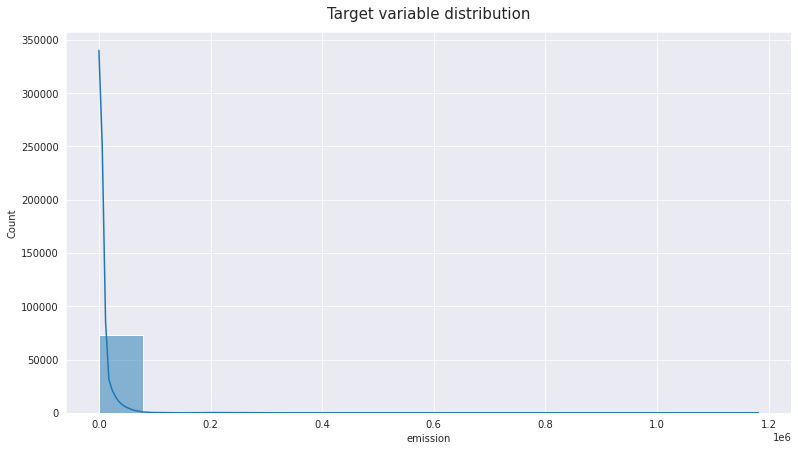

None

17.038027449698163

In [10]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

<a name="Outliers"></a>
## 4. Outliers


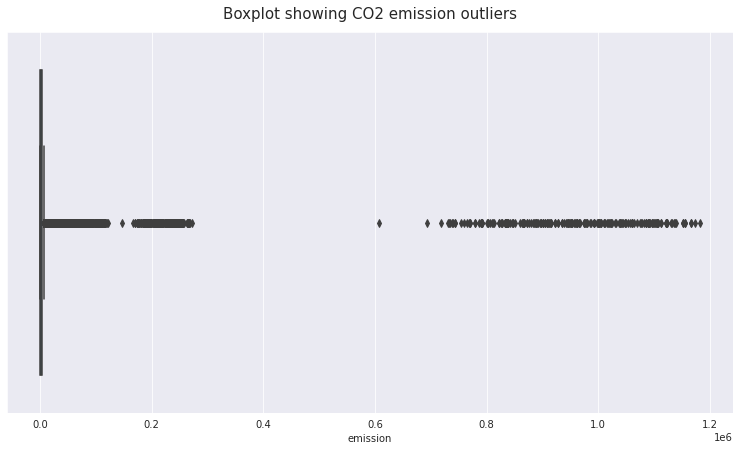

In [11]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [12]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
1,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
2,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
3,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
4,-23.73000,28.97000,train,POINT (28.97000 -23.73000)


In [13]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [14]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

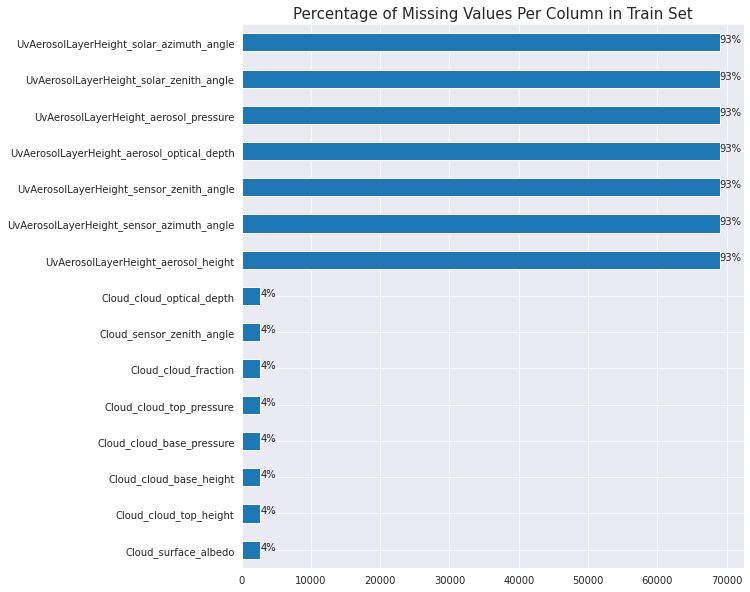

In [15]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [16]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Dates"></a>
## 7. Date features EDA

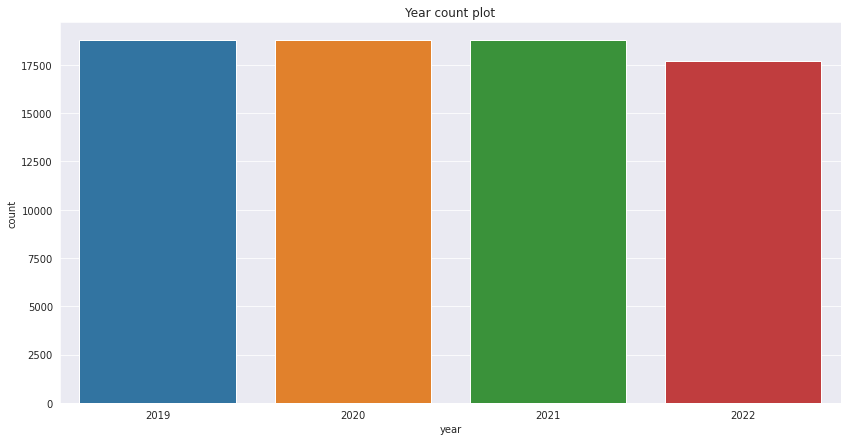

In [17]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

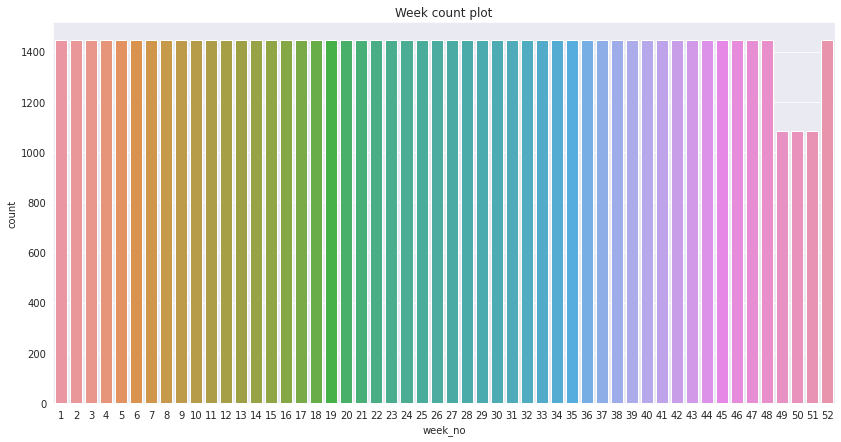

In [18]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [19]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


- The year 2022 has only 49 weeks available in the data

<a name="Correlations"></a>
## 8. Correlations - EDA

In [20]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                 1.00000
NitrogenDioxide_NO2_column_number_density                0.28840
NitrogenDioxide_tropospheric_NO2_column_number_density   0.28416
NitrogenDioxide_NO2_slant_column_number_density          0.24445
SulphurDioxide_SO2_column_number_density_15km            0.07252
SulphurDioxide_SO2_slant_column_number_density           0.06635
SulphurDioxide_SO2_column_number_density                 0.06020
Cloud_surface_albedo                                     0.05896
UvAerosolLayerHeight_sensor_azimuth_angle                0.05497
longitude                                                0.05394
UvAerosolIndex_sensor_altitude                           0.04477
UvAerosolLayerHeight_solar_azimuth_angle                 0.04376
latitude                                                 0.04372
NitrogenDioxide_sensor_altitude                          0.04069
UvAerosolLayerHeight_aerosol_optical_depth               0.04021
CarbonMonoxide_sensor_alt

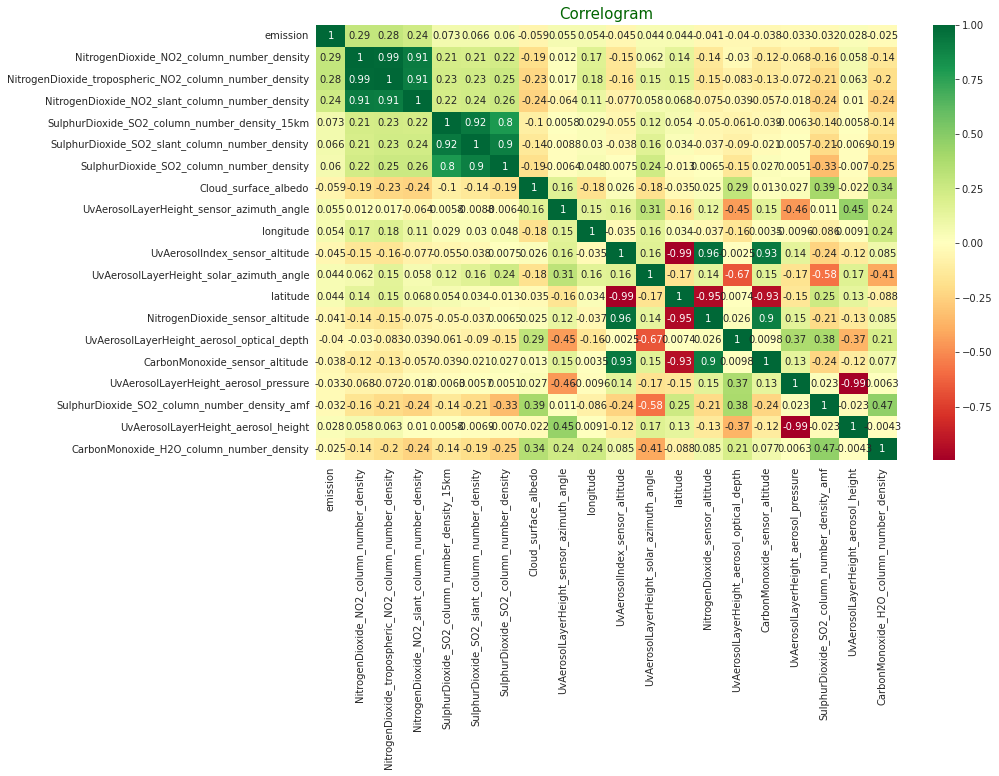

In [21]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

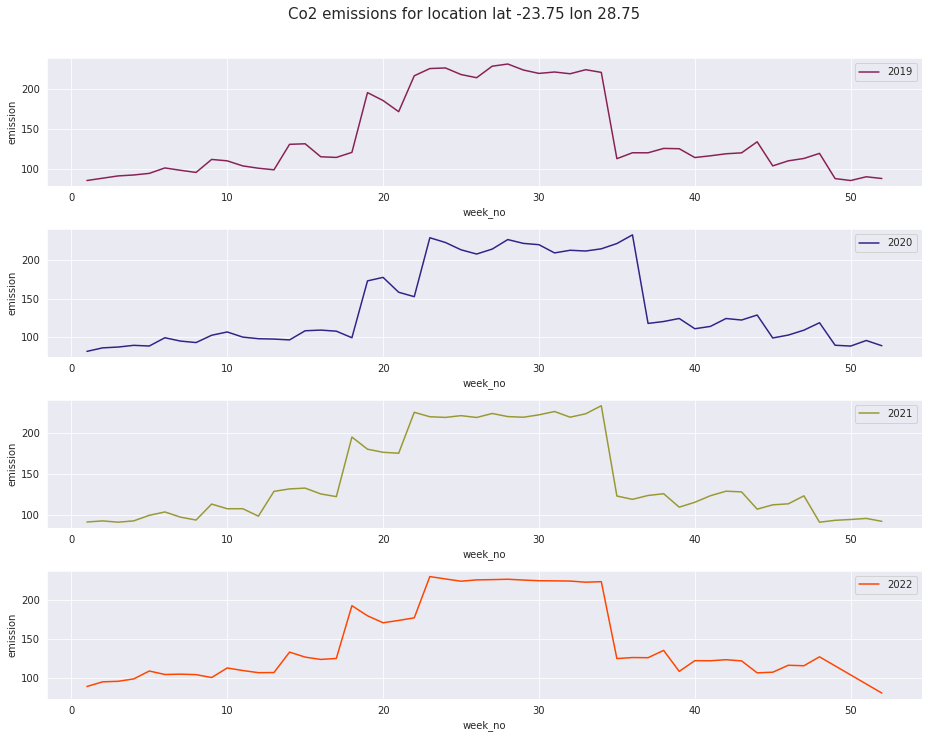

In [22]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(df.week_no, df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering









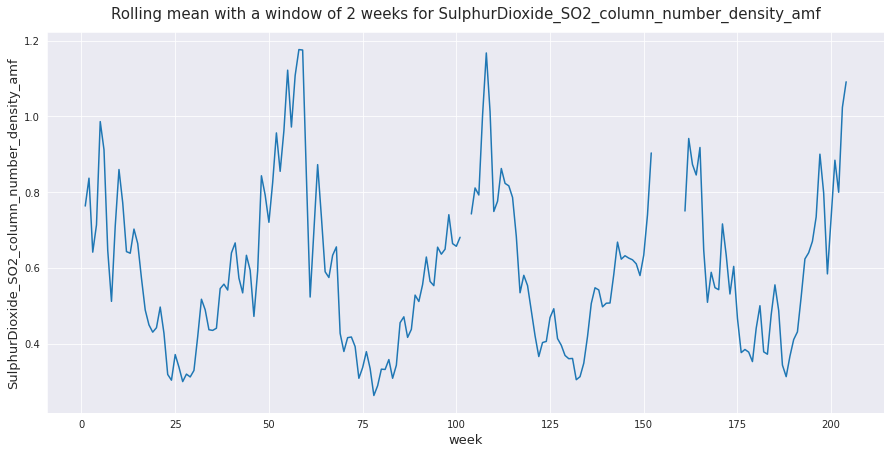

In [23]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

In [24]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00013,0.43882,0.00005,0.09470,-49.02600,55.93510,-92.36411,26.77170,0.00002,0.02549,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,0.00012,0.56813,0.00005,0.09466,-0.52002,44.99212,-88.07020,21.95860,0.00002,0.02503,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,0.00027,0.57377,0.00011,0.12280,-2.87484,47.10618,-82.84357,22.25336,0.00004,0.02369,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,0.00034,0.60875,0.00016,0.14627,-8.86249,49.32330,-77.79334,22.96216,0.00007,0.02297,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [25]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


<a name="Modelling"></a>
## 11.  Modelling

In [26]:
# Selecting the independent variables and the target variable

X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

RMSE Score: 23428.509884605068


In [27]:
X_test.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
36836,-28.13000,21.17000,2021,38,0.00036,0.40022,0.00011,0.12798,-11.32570,59.82414,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
54382,-29.63000,30.57000,2020,6,0.00026,0.70984,0.00018,0.05779,-9.54098,60.64862,...,87604.50758,1260.67845,89884.26150,1032.61928,11.00769,0.30485,-83.24249,46.66755,-70.86773,30.79264
59155,-29.83000,30.87000,2021,12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,75632.71146,2682.52049,84885.51320,1709.99876,24.75862,0.25198,-24.29842,53.13835,-42.77234,40.37883
49683,-29.43000,30.27000,2020,22,-0.00037,0.20361,-0.00006,0.19163,72.09401,61.25743,...,73195.13123,3085.13255,76128.15890,2684.23167,4.48731,0.22666,-12.33305,45.51857,-30.16216,57.40338
37156,-28.13000,21.37000,2019,52,-0.00005,1.06684,-0.00004,0.12360,-73.17503,31.04180,...,58558.74166,5226.07161,62264.91861,4586.63521,17.03806,0.37194,-41.16584,42.03886,-85.99270,27.40703


In [28]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

,latitude,longitude,year,week_no,emission,prediction,error
20432,-25.93000,29.37000,2021,34,992748.75000,36295.51296,956453.23704
20344,-25.93000,29.37000,2019,50,979504.20000,103261.03637,876243.16363
20362,-25.93000,29.37000,2020,16,867647.70000,12913.74035,854733.95965
20397,-25.93000,29.37000,2020,51,934806.80000,94880.18263,839926.61737
20458,-25.93000,29.37000,2022,8,835917.30000,11699.94290,824217.35710


In [29]:
pred_errors.tail()

,latitude,longitude,year,week_no,emission,prediction,error
35350,-28.03000,21.37000,2020,39,2.66638,2.66618,0.00019
43703,-28.63000,21.27000,2019,39,1.04626,1.04645,0.00019
30632,-27.03000,24.67000,2020,36,2.13081,2.13094,0.00013
35311,-28.03000,21.37000,2019,52,0.94331,0.94340,0.00009
39257,-28.23000,21.47000,2020,51,1.02328,1.02323,0.00005


In [30]:
train.emission.describe()

count     74005.00000
mean       7891.06097
std       52571.60466
min           0.04806
25%         154.54720
50%         723.13586
75%        2773.02930
max     1181701.20000
Name: emission, dtype: float64

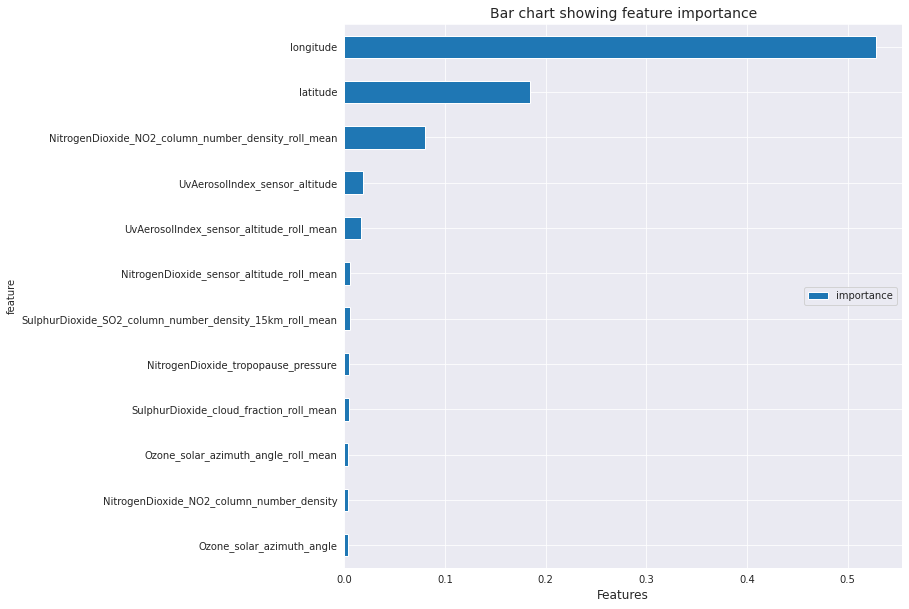

In [31]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [32]:
# Make prediction on the test set
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2712.14031
1,ID_-23.53_27.47_2019_2,2613.35232
2,ID_-23.53_27.47_2019_3,2596.63830
3,ID_-23.53_27.47_2019_4,2801.26996
4,ID_-23.53_27.47_2019_5,5014.14238


In [33]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;